In [1]:
import numpy as np
import sacpy as scp
import matplotlib.pyplot as plt
import xarray as xr

## Load Data

In [5]:
# load sst
sst = scp.load_sst()['sst']
# get ssta
ssta = scp.get_anom(sst,method=1)
# calculate Nino3.4
Nino34 = ssta.loc[:,-5:5,190:240].mean(axis=(1,2))

Nino34_ar = np.array(Nino34)
ssta_ar = np.array(ssta)

## Prepare Data

In [6]:
# for numpy.corrcoef
var_for_np = np.concatenate([ssta_ar.reshape((Nino34_ar.shape[0], -1)), 
        Nino34_ar[:, np.newaxis]], axis=1).T
var_for_np.shape

(16201, 496)

In [7]:
# for scipy cdist
from scipy.spatial.distance import cdist
x_for_scipy = ssta_ar.reshape((Nino34_ar.shape[0], -1)).T
y_for_scipy = Nino34_ar[:,np.newaxis].T


## Def Function

### for loop

In [8]:
import scipy.stats as sts

# For loop
def for_loop_reg(nino34, ssta):
    rvalue = np.zeros_like(ssta[0])
    p = np.zeros_like(ssta[0])
    for i in range(rvalue.shape[0]):
        for j in range(rvalue.shape[1]):
            res = sts.linregress(nino34, ssta[:, i, j])
            rvalue[i, j], p[i, j] = res.rvalue, res.pvalue
    return rvalue, p

### xarray apply_func

In [9]:
def GetSlopePv(data1, data2):
    res = sts.linregress(data2, data1)
    slope, intep, p_value, corr = res.slope, res.intercept, res.pvalue, res.rvalue
    return slope, intep, p_value, corr


def lingReg(data1, data2):
    """
    data1: y
    data2: x
    """
    dim0 = data1.dims[0]
    # print(dim0)
    return xr.apply_ufunc(GetSlopePv,
                          data1,
                          input_core_dims=[[dim0]],
                          kwargs={"data2": data2},
                          output_core_dims=[[], [], [], []],
                          vectorize=True)

In [ ]:
%time for i in range(50): xr.corr(ssta,Nino34,dim="time")

CPU times: user 7.8 s, sys: 0 ns, total: 7.8 s
Wall time: 7.84 s


In [ ]:
%time for i in range(50): scp.LinReg(Nino34_ar,ssta_ar)

CPU times: user 4.42 s, sys: 3.8 s, total: 8.22 s
Wall time: 1.54 s


In [ ]:
%time for i in range(50): rvalue, p = for_loop_reg(Nino34_ar, ssta_ar)

CPU times: user 1min 28s, sys: 0 ns, total: 1min 28s
Wall time: 1min 28s


In [ ]:
%time for i in range(50): np.corrcoef(var_for_np)

CPU times: user 9min 6s, sys: 1min 57s, total: 11min 3s
Wall time: 5min 10s


In [19]:
%time for i in range(50): cdist(x_for_scipy,y_for_scipy)

CPU times: user 1.7 s, sys: 2.67 s, total: 4.38 s
Wall time: 4.36 s


In [10]:
%time for i in range(50): lingReg(ssta,Nino34)

CPU times: user 2min 58s, sys: 62.5 ms, total: 2min 58s
Wall time: 2min 59s


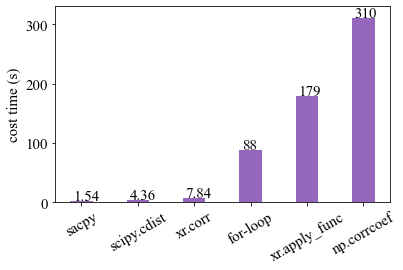

In [21]:
time_list = [1.54, 4.36, 7.84, 88,179, 310]
plt.subplots_adjust(bottom=0.2)
plt.rc('font', family='Times New Roman', size=15)
names = ["sacpy", "scipy.cdist", "xr.corr", "for-loop","xr.apply_func", "np.corrcoef"]
x = np.arange(6)
plt.bar(x, time_list, width=0.4, color="C4")
plt.xticks(x, names,rotation = 30)
for i in range(6):
    plt.text(x[i] - 0.15, time_list[i] + 1.1, list(map(lambda x: str(x), time_list))[i])
plt.ylabel("cost time (s)")
plt.ylim(0, 330)
plt.tight_layout
plt.savefig("../pic/speed_test_00.png",dpi=300)
